This notebook best viewed here: https://nbviewer.jupyter.org

This notebook is for the coastal variety of Douglas fir GEA mapping pops

#### Purpose
• I've run the baypass commands across four servers, I need to gather the jobs and concatenate results.

#### Notebook outline

- __rsync files from servers__
    - I execute the rsync commands to transfer files from the executing servers to our lab server
- __check what needs to be done__
    - given the number of gfiles and chains, make sure all of the commands have been executed/transferred
- __gather all of the wanted resfiles and concat into single dataframes__
    - gather the files with BF, label SNP IDs, and concat into single dataframe
- __Remove newREPEATS and add newSNPs__
    - after baypass was kicked off, we received an updated softmasked reference and some of the previous SNPs turned into REPEATS and some of the previous REPEATS turned into SNPs. From the baypass output, remove newREPEATS and add newSNPs
- __Rank loci__
    - Rank each locus for each chain by converting dB to BF (BF = 10^(dB / 10); dB = 10*log10(BF))
    - Caclulate mean BF across 5 chains, rank each locus based on mean
    - Create boolean column with True if locus is ranked in top 1% for at least 3/5 chains
    - Create boolean column with True if locus has BF >= 15 for at least 3/5 chains
    - Create boolean column with True if locus has BF >= 20 for at least 3/5 chains
- __look at BF scores for consistent top 1% ranks__
    - explore the top 1% of ranks
    - count number of SNPs >= BF thresholds {15, 20}, print if not all SNPs >= thresh are consistently in top 1% across chains

In [1]:
from pythonimports import *

In [2]:
# dir names
baydir = '/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass'
cmddir = op.join(baydir, 'cmd_files')
rundir = op.join(cmddir, 'run_01')
gfile_dir = op.join(baydir, 'individual_gfiles')
shdir = op.join(cmddir, 'shfiles')
resdir = op.join(cmddir, 'results')
rsyncdir = makedir(op.join(baydir, 'rsync_files'))

In [3]:
lview,dview = get_client()

56 56


# rsync files from servers

In [4]:
fs(rsyncdir)

['/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/rsync_files/arc_rsync_cmds.txt',
 '/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/rsync_files/beluga_rem_rsync_cmds.txt',
 '/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/rsync_files/beluga_rsync_cmds.txt',
 '/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/rsync_files/cedar_rem2_rsync_cmds.txt',
 '/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/rsync_files/cedar_rem_rsync_cmds.txt',
 '/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDinde

In [34]:
def exe(cmd):
    """execute system command."""
    import os
    os.system(cmd)

In [6]:
def submit_cmds(cmds):
    """Execute a list of system commands in parallel. Return cmd if there was an error."""
    jobs = []
    for cmd in nb(cmds):
        jobs.append(lview.apply_async(exe, cmd))
    watch_async(jobs)
    
    badcmds = []
    for i,j in enumerate(jobs):
        try:
            x=j.r
        except:
            badcmds.append(cmds[i])
    print('len(badcmds) = ', len(badcmds))
    
    return badcmds

In [37]:
def check_realfiles(cmds, new=False):
    """Make sure all transferred files exist.
    new is used if transferring the results from SNPs that were once REPEATS
    """
    realfiles = []
#     if new is True:
#         rundir = newrundir
#         gfile_dir = newgfiledir
#         shdir = newshdir
#         resdir = newresdir
    for d in [rundir, gfile_dir, shdir, resdir]:
        realfiles.extend(fs(d, dirs=False))
    
    expfiles = []
    for cmd in cmds:
        expfiles.append(cmd.split()[-1])
    
    print('len(realfiles) = ', len(realfiles))
    print('len(expfiles) =', len(expfiles))
    
    needed = list(set(expfiles) - set(realfiles))
    
    print('needed = ', len(needed))
    
    needed_cmds = []
    for n in needed:
        for cmd in cmds:
            if n in cmd:
                needed_cmds.append(cmd)
    print('needed_cmds = ', len(needed_cmds))
    return needed_cmds

#### cedar cmds

In [8]:
# first from cedar
# cmds = read(op.join(rsyncdir, 'cedar_rsync_cmds.txt'))
# cmds = read(op.join(rsyncdir, 'cedar_rem_rsync_cmds.txt'))
cmds = read(op.join(rsyncdir, 'cedar_rem2_rsync_cmds.txt'))
len(cmds)

417

In [9]:
dirs = []
for cmd in cmds:
    newfile = cmd.split()[-1]
    dname = op.dirname(newfile)
    dirs.append(dname)
for d in uni(dirs):
    assert op.exists(d)
d

'/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/cmd_files/results'

In [10]:
cmds[0]

'rsync -avz cedar:/scratch/lindb/coastal/cmd_files/results/coastal_all_snps_ADP-lt-1000_gfile_0627_chain_5_summary_beta_params.out /lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/cmd_files/results/coastal_all_snps_ADP-lt-1000_gfile_0627_chain_5_summary_beta_params.out'

In [11]:
badcmds = submit_cmds(cmds)

100%|██████████| 417/417 [00:00<00:00, 871.65it/s] 



Watching 417 jobs ...


100%|██████████| 417/417 [06:57<00:00,  1.00s/it]

len(badcmds) =  0


In [12]:
len(badcmds)

0

In [15]:
needed = check_realfiles(cmds)
len(needed)

len(realfiles) =  41643
len(expfiles) = 417
needed =  0
needed_cmds =  0


0

In [14]:
badcmds = submit_cmds(needed)

100%|██████████| 12/12 [00:00<00:00, 1909.97it/s]



Watching 12 jobs ...


100%|██████████| 12/12 [00:18<00:00,  1.57s/it]

len(badcmds) =  0


In [31]:
cmds = read('/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/rsync_files/cedar_rem3_rsync_cmds.txt')
len(cmds)

375

In [33]:
cmds[0]

'rsync -avz cedar:/scratch/lindb/coastal/cmd_files/results/coastal_all_snps_ADP-lt-1000_gfile_1094_chain_2_summary_pi_xtx.out /lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/cmd_files/results/coastal_all_snps_ADP-lt-1000_gfile_1094_chain_2_summary_pi_xtx.out'

In [39]:
badcmds = submit_cmds(needed)

100%|██████████| 13/13 [00:00<00:00, 2430.83it/s]



Watching 13 jobs ...


100%|██████████| 13/13 [00:09<00:00,  1.36it/s]

len(badcmds) =  0


In [40]:
needed = check_realfiles(cmds)

len(realfiles) =  42018
len(expfiles) = 375
needed =  0
needed_cmds =  0


#### arc cmds

In [9]:
arccmds = [cmd for cmd in read(op.join(rsyncdir, 'arc_rsync_cmds.txt')) if 'individual_gfiles' not in cmd]
len(arccmds)

3561

In [10]:
arcdicouts = [f for f in arccmds if 'DIC.out' in f]
len(arcdicouts)

672

In [11]:
dirs = []
for cmd in arccmds:
    newfile = cmd.split()[-1]
    dname = op.dirname(newfile)
    dirs.append(dname)
for d in uni(dirs):
    assert op.exists(d)
d

'/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/cmd_files/results'

In [12]:
len(arccmds)

3561

In [13]:
badcmds = submit_cmds(arccmds)

  0%|          | 4/3561 [00:00<01:41, 35.08it/s]


Watching 3561 jobs ...


100%|██████████| 3561/3561 [1:33:55<00:00,  1.58s/it]  

len(badcmds) =  0


In [17]:
needed, rev = check_realfiles(arccmds)
needed

0it [00:00, ?it/s]

len(realfiles) =  13236
len(expfiles) = 3561
reverse: =  9677
needed =  0
needed_cmds =  0


[]

#### beluga cmds

In [8]:
belugacmds = read(op.join(rsyncdir, 'beluga_rsync_cmds.txt'))
len(belugacmds)

14578

In [9]:
bdicouts = [f for f in belugacmds if 'DIC.out' in f]
len(bdicouts)

2890

In [11]:
rembelugacmds = read(op.join(rsyncdir, 'beluga_rem_rsync_cmds.txt'))
len(rembelugacmds)

6418

In [12]:
len(lview)

56

In [13]:
badcmds = submit_cmds(rembelugacmds)

100%|██████████| 6418/6418 [00:04<00:00, 1318.92it/s]



Watching 6418 jobs ...


100%|██████████| 6418/6418 [39:34<00:00,  2.70it/s]  


len(badcmds) =  0


In [17]:
needed = check_realfiles(rembelugacmds)

len(realfiles) =  41202
len(expfiles) = 6418
needed =  0
needed_cmds =  0


#### graham cmds

In [10]:
gcmds = read(op.join(rsyncdir, 'graham_rsync_cmds.txt'))
len(gcmds)

12209

In [11]:
gdicouts = [f for f in gcmds if 'DIC.out' in f]
len(gdicouts)

2421

In [12]:
thecmds = [cmd for cmd in belugacmds + gcmds if '.out' in cmd or '.sh' in cmd]
len(thecmds), len(belugacmds + gcmds)

(26787, 26787)

In [13]:
len([cmd for cmd in thecmds if cmd.endswith('.out')])

26671

In [14]:
lview,dview = get_client()

44 44


In [15]:
rem = [cmd for cmd in thecmds if not op.exists(cmd.split()[-1])]
len(rem), len(thecmds)

(32, 26787)

In [16]:
# badcmds = submit_cmds(cmds + belugacmds + gcmds)
# thecmds = [cmd for cmd in arccmds + gcmds if not 'individual_gfiles' in cmd]
badcmds = submit_cmds(rem)

  0%|          | 0/32 [00:00<?, ?it/s]


Watching 32 jobs ...


100%|██████████| 32/32 [00:07<00:00,  4.40it/s]

len(badcmds) =  0


In [19]:
needed,rev = check_realfiles(rem)

0it [00:00, ?it/s]

len(realfiles) =  36387
len(expfiles) = 32
reverse: =  36355
needed =  0
needed_cmds =  0


In [18]:
badcmds = submit_cmds(needed)

  0%|          | 0/9 [00:00<?, ?it/s]


Watching 9 jobs ...


100%|██████████| 9/9 [00:01<00:00,  4.65it/s]

len(badcmds) =  0


#### remaining arc and beluga cmds - these are jobs that didn't finish or were missing

In [ ]:
arccmds = read(op.join(rsyncdir, 'arc_rsync_cmds_remaining.txt'))
len(arccmds)

In [ ]:
belugacmds = read(op.join(rsyncdir, 'beluga_rsync_cmds_remaining.txt'))
len(belugacmds)

In [ ]:
allrem = arccmds + belugacmds
len(allrem)

In [ ]:
badcmds = submit_cmds(allrem)

In [ ]:
needed = []
for cmd in nb(allrem):
    file = op.realpath(cmd.split()[-1])
    if not op.exists(file):
        needed.append(cmd)
len(needed)

#### newsnp cmds from graham

In [8]:
cmds = read('/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/rsync_files/graham_new_rsync_cmds.txt')
len(cmds)

202

In [9]:
cmds[0]

'rsync -avz graham:/scratch/lindb/coastal/new_cmd_files/new_shfiles/batch_0000.sh /data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/cmd_files/new_shfiles/batch_0000.sh'

In [65]:
?check_realfiles

In [14]:
newrundir = op.realpath('/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/cmd_files/run_02')
newshdir = op.realpath('/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/cmd_files/new_shfiles')
newgfiledir = op.realpath('/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/cmd_files/new_individual_gfiles')
newresdir = op.realpath('/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/cmd_files/new_results')

In [67]:
# make sure they don't exist (except for .sh file)
needed,real,exp = check_realfiles(cmds, new=True)

len(realfiles) =  18
len(expfiles) = 5
needed =  4
needed_cmds =  4


In [18]:
badcmds = submit_cmds(needed)

100%|██████████| 5/5 [00:00<00:00, 1314.91it/s]



Watching 5 jobs ...


100%|██████████| 5/5 [00:00<00:00, 26.06it/s]

len(badcmds) =  0


In [19]:
needed = check_realfiles(cmds, new=True)

len(realfiles) =  219
len(expfiles) = 202
needed =  0
needed_cmds =  0


# check what needs to be done
given the number of gfiles and chains, make sure all of the commands have been executed/transferred

#### first check to make sure every sh file was exececuted (ie, check that each has a slurm .out file)

In [41]:
# the the shfiles and out files
shfiles = fs(shdir, endswith='.sh')
outs = fs(shdir, endswith='.out')
len(shfiles), len(outs)

(161, 170)

In [42]:
# which sh files were not run, print out any that weren't run
pairs = {}
for sh in shfiles:
    pairs[sh] = []
    for out in outs:
        if op.basename(sh).split(".")[0] in out:
            pairs[sh].append(out)
needed = []
for sh,outfiles in pairs.items():
    if len(outfiles) < 1:
        print(sh, len(outfiles))
        needed.append(sh)

In [22]:
# go and run these jobs ^ on beluga

#### go through catfiles and make sure all of the commands inside were run

In [43]:
resdir

'/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/cmd_files/results'

In [44]:
# get one of the files for each of the commands that executed successfully (count the succesful cmds)
resfiles = fs(resdir, endswith='DIC.out')
len(resfiles)

7690

In [45]:
# get the files with the baypass commands - this matches number of sh files (good)
catfiles = fs(rundir, pattern='catfile')
len(catfiles)

161

In [46]:
# iterate through catfile commands and make sure there's a result for each
found = {}  # map prefix to output file
exe = {}  # map prefix to command used
needed_catfiles = []
catcount = Counter()
cmdcats = {}  # map cmds to catfiles
for cat in nb(catfiles):
    # get the commands
    cmds = read(cat)
    
    # assign prefixes (= num cmds) to their output
    notfound = True
    for cmd in cmds:
        assert cmd not in cmdcats
        cmdcats[cmd] = cat
        prefix = cmd.split("-outprefix")[1].split()[0]
        assert prefix not in found and 'chain' in prefix
        exe[prefix] = cmd
        found[prefix] = []
        for res in resfiles:
            if prefix in op.basename(res):
                found[prefix].append(res)
        if len(found[prefix]) > 0:
            notfound = False
            catcount[cat] += 1
    if notfound is True:
        needed_catfiles.append(cat)
            
prefix

100%|██████████| 161/161 [00:41<00:00,  3.85it/s]


'coastal_all_snps_ADP-lt-1000_gfile_1537_chain_5'

In [47]:
len(needed_catfiles)

0

In [48]:
Counter(catcount.values())

Counter({48: 160, 10: 1})

In [49]:
needed_catfiles

[]

In [50]:
# figure out which prefixes have zero output (and need to be reran) or cmds with >1 output (impossible...)
needed_cmds = []
for prefix,reslist in found.items():
    if len(reslist) == 0:
        needed_cmds.append(exe[prefix])  # get the cmd that needs to be executed
    elif len(reslist) > 1:
        print('\n', prefix, len(reslist))  # this shouldn't be possible, check anyway, print if so
len(needed_cmds)

0

In [51]:
cats = []
for cmd in needed_cmds:
    cats.append(cmdcats[cmd])

In [52]:
luni(cats)

0

In [41]:
for cat in suni(cats):
    print(cat, catcount[cat])

/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/cmd_files/run_01/catfile_0113.txt 33
/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/cmd_files/run_01/catfile_0114.txt 41
/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/cmd_files/run_01/catfile_0115.txt 38
/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/cmd_files/run_01/catfile_0116.txt 38
/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/cmd_files/run_01/catfile_0118.txt 40
/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_vari

#### these cmds didn't execute first round

In [42]:
# create catfiles with the remaining commands
rundir = makedir(op.join(cmddir, 'run_remaining'))
towrite = []
newfiles = []
for i,cmd in enumerate(needed_cmds):
    towrite.append(cmd)
    if len(towrite) == 48 or (i+1) == len(needed_cmds):
        file = op.join(rundir, 'remaining_catfile_%s.txt' % str(len(newfiles)))
        print(i, len(towrite), file)
        newfiles.append(file)
        with open(file, 'w') as o:
            o.write("%s" % '\n'.join(towrite))
        towrite = []
file

47 48 /lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/cmd_files/run_remaining/remaining_catfile_0.txt
74 27 /lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/cmd_files/run_remaining/remaining_catfile_1.txt


'/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/cmd_files/run_remaining/remaining_catfile_1.txt'

In [43]:
for f in newfiles:
    print(len(read(f)), op.basename(f))

48 remaining_catfile_0.txt
27 remaining_catfile_1.txt


In [44]:
# print rsync cmds to execute in command line
for f in newfiles:
    print(f'rsync -azv {f} cedar:/home/lindb/scratch/coastal/cmd_files/run_remaining/{op.basename(f)}')

rsync -azv /lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/cmd_files/run_remaining/remaining_catfile_0.txt cedar:/home/lindb/scratch/coastal/cmd_files/run_remaining/remaining_catfile_0.txt
rsync -azv /lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/cmd_files/run_remaining/remaining_catfile_1.txt cedar:/home/lindb/scratch/coastal/cmd_files/run_remaining/remaining_catfile_1.txt


In [68]:
# create slurm.sh files for leftover commands
cdir = '/home/lindb/scratch/coastal/cmd_files/run_remaining'
for f in newfiles:
    cfile = op.join(cdir, op.basename(f))
    num = op.basename(f).split("_")[-1].split(".")[0]
    text = f'''#!/bin/bash
#SBATCH --job-name=remaining_{num}
#SBATCH --time=2-00:00:00
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --mem-per-cpu=25
#SBATCH --cpus-per-task=48
#SBATCH --output=remaining_{num}_%j.out
#SBATCH --mail-user=lindb@vcu.edu
#SBATCH --mail-type=FAIL

export PATH="${{PATH}}:/project/def-saitken/programs/baypass_2.2/sources"

cd /scratch/lindb/coastal/cmd_files/results

cat {cfile} | parallel -j 48 --progress

source $HOME/py3/bin/activate
cd $HOME/pipeline
python balance_queue.py lindb /home/lindb
'''
    shfile = op.join(rundir, f'remaining_{num}.sh')
    print(f'scp {shfile} cedar:/home/lindb/scratch/coastal/cmd_files/run_remaining')
    with open(shfile, 'w') as o:
        o.write("%s" % text)

scp /lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/cmd_files/run_remaining/remaining_0.sh cedar:/home/lindb/scratch/coastal/cmd_files/run_remaining
scp /lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/cmd_files/run_remaining/remaining_1.sh cedar:/home/lindb/scratch/coastal/cmd_files/run_remaining


In [ ]:
# scp to cedar and run

# gather all of the wanted resfiles and concat into single dataframes

gather the files with BF, label SNP IDs, label environmental covariables, and concat into single dataframe

#### first get SNPs that were in the origal SNPs 

These gfiles were created before we got the updated softmasked reference. Not all of these are still SNPs, some are now REPEATs

In [ ]:
# restart notebook

In [4]:
lview,dview = get_client()

43 43


In [5]:
bffiles = fs(resdir, endswith='betai_reg.out')
xtxfiles = fs(resdir, endswith='pi_xtx.out')
len(bffiles), len(xtxfiles)

(7690, 7690)

In [6]:
bf = pd.read_table(bffiles[0], delim_whitespace=True)
bf.head()

,COVARIABLE,MRK,M_Pearson,SD_Pearson,BF(dB),Beta_is,SD_Beta_is,eBPis
0,1,1,0.030380,0.150714,-8.422483,0.002297,0.012573,0.068009
1,1,2,0.083643,0.141793,-7.080080,0.006720,0.011477,0.253198
2,1,3,-0.011462,0.156535,-11.379507,-0.001112,0.007223,0.056671
3,1,4,-0.097044,0.124009,-11.050299,-0.005155,0.007332,0.316950
4,1,5,0.025869,0.145066,-11.300727,0.001124,0.008051,0.051126


In [7]:
xtx = pd.read_table(xtxfiles[0], delim_whitespace=True)
xtx.head()

,MRK,M_P,SD_P,M_XtX,SD_XtX,XtXst,log10(1/pval)
0,1,0.898686,0.063788,38.186459,8.547612,29.143439,0.087171
1,2,0.906177,0.055326,37.996246,8.488336,33.489468,0.197635
2,3,0.969151,0.025090,35.623686,8.392927,15.339147,0.000277
3,4,0.957474,0.044406,36.263510,8.341104,45.262135,0.781979
4,5,0.954015,0.024726,35.999887,8.420881,29.581775,0.095814


In [9]:
def label_snps(resfile):
    """Label baypass resfiles with SNP ID using pkl files saved in 002_kickoff."""
    import os
    import pandas
    # find the gfile associated with resfile
    prefix = os.path.basename(resfile).split("_chain")[0]
    chain = "chain_%s" % os.path.basename(resfile).split(prefix)[1].split("_")[2]
    
    # get the pkl file that has the ordered list of SNP IDs for the gfile
    if 'new' in resfile:
        newgfile_dir = os.path.dirname(resfile).replace("new_results", "new_individual_gfiles")
        pklfile = os.path.join(newgfile_dir, f'{prefix}_noheaderidx.pkl')
    else:
        pklfile = os.path.join(gfile_dir, f'{prefix}_noheaderidx.pkl')
    gloci = pklload(pklfile)  # read in rows with SNPIDs, but only one column
    
    # read in the resfile
    df = pandas.read_table(resfile, delim_whitespace=True)
    
    # map MRK column (SNP index) to locus name
    gdict = dict((num+1, locus) for num,locus in enumerate(gloci))
    
    # map covariable column to environment ID
    edict = dict((num+1, env) for num,env in enumerate(efile.index))
    
    # split each covariable (env) in to its own file, label index with SNP ID
    df['env'] = df['COVARIABLE'].map(edict)
    envdfs = {chain:{}}
    for env in uni(df['env']):
        envdfs[chain][env] = df[df['env']==env].copy()
        envdfs[chain][env].index = envdfs[chain][env]['MRK'].map(gdict)
        envdfs[chain][env].index.names = ['']

    return envdfs

efile = pd.read_table(op.join(baydir, 'coastal_efile_std_HEADERIDX.txt'), index_col=0, usecols=[0,1])
dview['efile'] = efile
dview['uni'] = uni
dview['gfile_dir'] = gfile_dir
dview['pklload'] = pklload

In [31]:
# label SNP IDs in parallel
jobs = []
for bffile in nb(bffiles):
    jobs.append(lview.apply_async(label_snps, bffile))
watch_async(jobs)


Watching 7690 jobs ...


100%|██████████| 7690/7690 [00:09<00:00, 804.56it/s] 


In [32]:
# gather output by environment
envlist = {}
for j in nb(jobs):
    if j.ready():
        chain = keys(j.r)[0]
        if chain not in envlist:
            envlist[chain] = {}
        for env in j.r[chain]:
            if env not in envlist[chain]:
                envlist[chain][env] = []
            envlist[chain][env].append(j.r[chain][env])
keys(envlist)

100%|██████████| 7690/7690 [00:00<00:00, 21292.09it/s]


['chain_1', 'chain_2', 'chain_3', 'chain_4', 'chain_5']

In [33]:
# concatenate environmental output by each chain, print out num snps for each env for each chain
chaindfs = {}
for chain,envs in envlist.items():
    assert len(envs) == 19
    if chain not in chaindfs:
        chaindfs[chain] = {}
    for env,dfs in nb(envs.items(), desc=chain):
        if env not in chaindfs[chain]:
            chaindfs[chain][env] = pd.concat(dfs)
        else:
            print('crap ', chain, env)
for chain in chaindfs:
    print(ColorText(chain).bold())
    for env in chaindfs[chain]:
        print('\t',env, nrow(chaindfs[chain][env]))

chain_5: 100%|██████████| 19/19 [00:10<00:00,  1.82it/s]

chain_1
	 FFP 2305827
	 Eref 2305827
	 SHM 2305827
	 PAS 2305827
	 MAT 2305827
	 EMT 2305827
	 bFFP 2305827
	 DD5 2305827
	 NFFD 2305827
	 MCMT 2305827
	 MWMT 2305827
	 DD_0 2305827
	 EXT 2305827
	 eFFP 2305827
	 MSP 2305827
	 AHM 2305827
	 CMD 2305827
	 MAP 2305827
	 TD 2305827
chain_2
	 FFP 2305827
	 MAP 2305827
	 CMD 2305827
	 TD 2305827
	 MWMT 2305827
	 Eref 2305827
	 SHM 2305827
	 AHM 2305827
	 MCMT 2305827
	 PAS 2305827
	 bFFP 2305827
	 eFFP 2305827
	 DD5 2305827
	 EXT 2305827
	 DD_0 2305827
	 MAT 2305827
	 MSP 2305827
	 EMT 2305827
	 NFFD 2305827
chain_3
	 bFFP 2305827
	 EMT 2305827
	 TD 2305827
	 NFFD 2305827
	 CMD 2305827
	 MWMT 2305827
	 MAP 2305827
	 SHM 2305827
	 DD_0 2305827
	 FFP 2305827
	 MAT 2305827
	 MSP 2305827
	 eFFP 2305827
	 MCMT 2305827
	 Eref 2305827
	 EXT 2305827
	 PAS 2305827
	 DD5 2305827
	 AHM 2305827
chain_4
	 CMD 2305827
	 AHM 2305827
	 EXT 2305827
	 DD5 2305827
	 bFFP 2305827
	 PAS 2305827
	 SHM 2305827
	 EMT 2305827
	 DD_0 2305827
	 MWMT 2305827
	 Eref 23

In [34]:
# concatenate environmental output by each env, combine chains into single df
dflst = {}
for chain,envs in envlist.items():
    for env,dfs in nb(envs.items(), desc=chain):
        if env not in dflst:
            dflst[env] = []
        df = pd.concat(dfs)
        df.columns = [f"{chain}-{col}" for col in df.columns]
        dflst[env].append(df)
# combine chains for each env - should have done this in parallel
envdfs = {}
for env,lst in nb(dflst.items(), desc='combo'):
    assert len(lst) == 5
    df = pd.merge(lst[0], lst[1], left_index=True, right_index=True)
    df2 = pd.merge(lst[2], lst[3], left_index=True, right_index=True)
    df3 = pd.merge(df, df2, left_index=True, right_index=True)
    envdfs[env] = pd.merge(df3, lst[4], left_index=True, right_index=True)
    
    
envdfs[env].head()           

combo: 100%|██████████| 19/19 [03:24<00:00, 10.75s/it]


,chain_1-COVARIABLE,chain_1-MRK,chain_1-M_Pearson,chain_1-SD_Pearson,chain_1-BF(dB),chain_1-Beta_is,chain_1-SD_Beta_is,chain_1-eBPis,chain_1-env,chain_2-COVARIABLE,chain_2-MRK,chain_2-M_Pearson,chain_2-SD_Pearson,chain_2-BF(dB),chain_2-Beta_is,chain_2-SD_Beta_is,chain_2-eBPis,chain_2-env,chain_3-COVARIABLE,chain_3-MRK,chain_3-M_Pearson,chain_3-SD_Pearson,chain_3-BF(dB),chain_3-Beta_is,chain_3-SD_Beta_is,chain_3-eBPis,chain_3-env,chain_4-COVARIABLE,chain_4-MRK,chain_4-M_Pearson,chain_4-SD_Pearson,chain_4-BF(dB),chain_4-Beta_is,chain_4-SD_Beta_is,chain_4-eBPis,chain_4-env,chain_5-COVARIABLE,chain_5-MRK,chain_5-M_Pearson,chain_5-SD_Pearson,chain_5-BF(dB),chain_5-Beta_is,chain_5-SD_Beta_is,chain_5-eBPis,chain_5-env
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
jcf7190000000000-77738,4,1,0.052606,0.139252,-8.509406,0.004511,0.012685,0.141382,TD,4,1,0.047391,0.139289,-9.269721,0.003929,0.011932,0.129636,TD,4,1,0.054793,0.141939,-7.948701,0.004884,0.012312,0.160125,TD,4,1,0.040790,0.143065,-8.247926,0.003447,0.012262,0.108679,TD,4,1,0.044477,0.136319,-9.383110,0.003829,0.012267,0.122097,TD
jcf7190000000000-77764,4,2,0.055272,0.149463,-8.537988,0.004356,0.013015,0.132021,TD,4,2,0.079474,0.145473,-8.024145,0.006985,0.013533,0.217692,TD,4,2,0.077141,0.125644,-8.818893,0.006700,0.011436,0.253422,TD,4,2,0.055892,0.140073,-8.688561,0.004729,0.013162,0.143030,TD,4,2,0.070906,0.138991,-8.601899,0.005808,0.011649,0.208963,TD
jcf7190000000004-54418,4,3,0.022225,0.155169,-11.121776,0.001822,0.007886,0.087604,TD,4,3,0.018410,0.151466,-11.649164,0.001445,0.007233,0.074889,TD,4,3,0.025411,0.152883,-11.195197,0.001824,0.007524,0.092361,TD,4,3,0.029393,0.155451,-10.883782,0.002118,0.007755,0.105274,TD,4,3,0.020913,0.155163,-8.300746,0.001655,0.007495,0.083397,TD
jcf7190000000004-54508,4,4,0.160345,0.119940,-8.376227,0.009439,0.008651,0.560282,TD,4,4,0.153904,0.119523,-8.345275,0.008835,0.008046,0.565179,TD,4,4,0.158885,0.116715,-8.996210,0.008835,0.007458,0.626842,TD,4,4,0.178100,0.123841,-7.792464,0.010440,0.009024,0.606771,TD,4,4,0.162778,0.115872,-8.616263,0.009363,0.008113,0.604681,TD
jcf7190000000004-54540,4,5,-0.152640,0.141437,-6.963774,-0.008843,0.008903,0.494021,TD,4,5,-0.139895,0.137734,-7.349303,-0.007856,0.008444,0.453218,TD,4,5,-0.147504,0.142572,-6.728656,-0.008443,0.008913,0.464098,TD,4,5,-0.146215,0.139645,-6.483963,-0.008384,0.008727,0.472768,TD,4,5,-0.135771,0.141118,-6.958119,-0.007717,0.008917,0.412503,TD


In [36]:
# how many SNPs should be in each env file?
# read in each of the gfiles and sum rows
rows = 0
for gfile in nb(fs(gfile_dir, pattern='noheaderidx.txt')):
    df = pd.read_table(gfile, usecols=[0], header=None)
    rows += nrow(df)
rows

100%|██████████| 1538/1538 [00:12<00:00, 125.63it/s]


2305827

In [37]:
# assert each env has the expected number of rows (SNPs)
for env in envdfs:
    print(ColorText(env).bold())
    print('\t',env, nrow(envdfs[env]))
    if nrow(envdfs[env]) != rows:
        print(ColorText('CRAAAAAAAAAP').fail().bold())

FFP
	 FFP 2305827
Eref
	 Eref 2305827
SHM
	 SHM 2305827
PAS
	 PAS 2305827
MAT
	 MAT 2305827
EMT
	 EMT 2305827
bFFP
	 bFFP 2305827
DD5
	 DD5 2305827
NFFD
	 NFFD 2305827
MCMT
	 MCMT 2305827
MWMT
	 MWMT 2305827
DD_0
	 DD_0 2305827
EXT
	 EXT 2305827
eFFP
	 eFFP 2305827
MSP
	 MSP 2305827
AHM
	 AHM 2305827
CMD
	 CMD 2305827
MAP
	 MAP 2305827
TD
	 TD 2305827


In [38]:
# release some RAM
del dflst, chaindfs, df, df2, df3, dfs, envlist, jobs

# Remove newREPEATS and add newSNPs

after baypass was kicked off, we received an updated softmasked reference and some of the previous SNPs turned into REPEATS and some of the previous REPEATS turned into SNPs. From the baypass output, remove newREPEATS and add newSNPs

#### add newSNPs

In [39]:
newresdir = op.join(cmddir, 'new_results')
newresdir

'/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/cmd_files/new_results'

In [40]:
newbffiles = fs(newresdir, endswith='betai_reg.out')
newxtxfiles = fs(newresdir, endswith='pi_xtx.out')
len(newbffiles), len(newxtxfiles)

(40, 40)

In [41]:
jobs = []
for bffile in nb(newbffiles):
    jobs.append(lview.apply_async(label_snps, bffile))
watch_async(jobs)

100%|██████████| 40/40 [00:00<00:00, 1419.91it/s]



Watching 40 jobs ...


100%|██████████| 40/40 [00:00<00:00, 193956.25it/s]


In [42]:
# gather output by environment
newenvlist = {}
for j in nb(jobs):
    assert len(keys(j.r)) == 1
    chain = keys(j.r)[0]
    if chain not in newenvlist:
        newenvlist[chain] = {}
    for env in j.r[chain]:
        if env not in newenvlist[chain]:
            newenvlist[chain][env] = []
        newenvlist[chain][env].append(j.r[chain][env])
keys(newenvlist)

100%|██████████| 40/40 [00:00<00:00, 15460.02it/s]


['chain_1', 'chain_2', 'chain_3', 'chain_4', 'chain_5']

In [43]:
# concatenate environmental output by each chain, print out num snps for each env for each chain
newchaindfs = {}
for chain,envs in newenvlist.items():
    assert len(envs) == 19
    if chain not in newchaindfs:
        newchaindfs[chain] = {}
    for env,dfs in nb(envs.items(), desc=chain):
        if env not in newchaindfs[chain]:
            newchaindfs[chain][env] = pd.concat(dfs)
        else:
            print('crap ', chain, env)
for chain in newchaindfs:
    print(ColorText(chain).bold())
    for env in newchaindfs[chain]:
        print('\t',env, nrow(newchaindfs[chain][env]))

chain_5: 100%|██████████| 19/19 [00:00<00:00, 578.46it/s]

chain_1
	 FFP 1924
	 SHM 1924
	 PAS 1924
	 Eref 1924
	 MAP 1924
	 MSP 1924
	 MAT 1924
	 TD 1924
	 DD5 1924
	 eFFP 1924
	 NFFD 1924
	 EMT 1924
	 MWMT 1924
	 EXT 1924
	 bFFP 1924
	 AHM 1924
	 CMD 1924
	 MCMT 1924
	 DD_0 1924
chain_2
	 FFP 1924
	 EMT 1924
	 AHM 1924
	 DD_0 1924
	 Eref 1924
	 eFFP 1924
	 EXT 1924
	 MAT 1924
	 MSP 1924
	 NFFD 1924
	 SHM 1924
	 MCMT 1924
	 CMD 1924
	 TD 1924
	 DD5 1924
	 MAP 1924
	 MWMT 1924
	 bFFP 1924
	 PAS 1924
chain_3
	 MAP 1924
	 bFFP 1924
	 PAS 1924
	 TD 1924
	 Eref 1924
	 SHM 1924
	 DD5 1924
	 MSP 1924
	 eFFP 1924
	 MCMT 1924
	 AHM 1924
	 MWMT 1924
	 EXT 1924
	 CMD 1924
	 MAT 1924
	 EMT 1924
	 DD_0 1924
	 NFFD 1924
	 FFP 1924
chain_4
	 MCMT 1924
	 EMT 1924
	 MAT 1924
	 PAS 1924
	 NFFD 1924
	 FFP 1924
	 MWMT 1924
	 CMD 1924
	 DD5 1924
	 DD_0 1924
	 TD 1924
	 MSP 1924
	 AHM 1924
	 eFFP 1924
	 SHM 1924
	 Eref 1924
	 MAP 1924
	 bFFP 1924
	 EXT 1924
chain_5
	 CMD 1924
	 DD5 1924
	 FFP 1924
	 MAP 1924
	 MAT 1924
	 AHM 1924
	 DD_0 1924
	 SHM 1924
	 MCMT 1924

In [44]:
# concatenate environmental output by each env, combine chains into single df
newdflst = {}
for chain,envs in newenvlist.items():
    for env,dfs in nb(envs.items(), desc=chain):
        if env not in newdflst:
            newdflst[env] = []
        df = pd.concat(dfs)
        df.columns = [f"{chain}-{col}" for col in df.columns]
        newdflst[env].append(df)
# combine chains for each env - should have done this in parallel
newenvdfs = {}
for env,lst in nb(newdflst.items(), desc='combo'):
    assert len(lst) == 5
    df = pd.merge(lst[0], lst[1], left_index=True, right_index=True)
    df2 = pd.merge(lst[2], lst[3], left_index=True, right_index=True)
    df3 = pd.merge(df, df2, left_index=True, right_index=True)
    newenvdfs[env] = pd.merge(df3, lst[4], left_index=True, right_index=True)
    
    
newenvdfs[env].head()           

combo: 100%|██████████| 19/19 [00:00<00:00, 45.68it/s]


,chain_1-COVARIABLE,chain_1-MRK,chain_1-M_Pearson,chain_1-SD_Pearson,chain_1-BF(dB),chain_1-Beta_is,chain_1-SD_Beta_is,chain_1-eBPis,chain_1-env,chain_2-COVARIABLE,chain_2-MRK,chain_2-M_Pearson,chain_2-SD_Pearson,chain_2-BF(dB),chain_2-Beta_is,chain_2-SD_Beta_is,chain_2-eBPis,chain_2-env,chain_3-COVARIABLE,chain_3-MRK,chain_3-M_Pearson,chain_3-SD_Pearson,chain_3-BF(dB),chain_3-Beta_is,chain_3-SD_Beta_is,chain_3-eBPis,chain_3-env,chain_4-COVARIABLE,chain_4-MRK,chain_4-M_Pearson,chain_4-SD_Pearson,chain_4-BF(dB),chain_4-Beta_is,chain_4-SD_Beta_is,chain_4-eBPis,chain_4-env,chain_5-COVARIABLE,chain_5-MRK,chain_5-M_Pearson,chain_5-SD_Pearson,chain_5-BF(dB),chain_5-Beta_is,chain_5-SD_Beta_is,chain_5-eBPis,chain_5-env
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
jcf7190000000173-53782,9,1,-0.043086,0.140228,-9.671238,-0.003895,0.011570,0.132905,DD_0,9,1,-0.045174,0.132741,-5.342276,-0.004140,0.010953,0.151550,DD_0,9,1,-0.034366,0.129188,-10.604734,-0.003068,0.009737,0.123368,DD_0,9,1,-0.031981,0.141979,-8.937414,-0.003145,0.011849,0.101993,DD_0,9,1,-0.055836,0.137111,-9.433134,-0.005157,0.011405,0.186313,DD_0
jcf7190000000173-53833,9,2,-0.166846,0.105270,-7.058093,-0.016280,0.009903,0.999195,DD_0,9,2,-0.159835,0.107259,-6.728115,-0.015501,0.010522,0.851702,DD_0,9,2,-0.163185,0.098827,-7.194402,-0.015904,0.009184,1.079273,DD_0,9,2,-0.164436,0.110605,-6.328030,-0.015916,0.010376,0.902979,DD_0,9,2,-0.157191,0.104888,-7.305745,-0.015184,0.009718,0.927457,DD_0
jcf7190000000173-53870,9,3,-0.120392,0.139550,-8.671335,-0.007380,0.008563,0.410247,DD_0,9,3,-0.111166,0.133610,-9.165615,-0.006955,0.008299,0.395772,DD_0,9,3,-0.122058,0.135319,-8.871418,-0.007407,0.008157,0.439074,DD_0,9,3,-0.120436,0.137590,-8.342317,-0.007198,0.008186,0.421086,DD_0,9,3,-0.116626,0.131984,-8.851803,-0.007503,0.008490,0.423837,DD_0
jcf7190000000173-53990,9,4,0.145188,0.094966,-7.759643,0.014846,0.009461,0.933175,DD_0,9,4,0.146852,0.093694,-8.014668,0.014923,0.009323,0.960763,DD_0,9,4,0.138295,0.099440,-8.060055,0.014058,0.009843,0.814631,DD_0,9,4,0.138303,0.101826,-8.179976,0.013889,0.009862,0.798491,DD_0,9,4,0.135183,0.096796,-8.456722,0.013663,0.009409,0.834239,DD_0
jcf7190000000173-54077,9,5,0.114041,0.103352,-8.541131,0.012676,0.010725,0.624756,DD_0,9,5,0.099408,0.103388,-8.750579,0.011094,0.010595,0.530124,DD_0,9,5,0.103625,0.105787,-8.791820,0.011423,0.010706,0.543629,DD_0,9,5,0.103573,0.100145,-9.082215,0.011239,0.010038,0.580257,DD_0,9,5,0.099753,0.102363,-9.040670,0.011215,0.010514,0.543430,DD_0


In [45]:
newenvdfs[env].shape

(1924, 45)

In [46]:
newgfile_dir = op.join(cmddir, 'new_individual_gfiles')
op.exists(newgfile_dir)

True

In [47]:
# how many SNPs should be in each env file?
newrows = 0
for gfile in nb(fs(newgfile_dir, pattern='noheaderidx.txt')):
    df = pd.read_table(gfile, usecols=[0], header=None)
    newrows += nrow(df)
newrows

100%|██████████| 8/8 [00:00<00:00, 64.24it/s]


1924

In [48]:
# make sure that many SNPs are in each env file
for env in newenvdfs:
    print(ColorText(env).bold())
    print('\t',env, nrow(newenvdfs[env]))
    if nrow(newenvdfs[env]) != newrows:
        print(ColorText('CRAAAAAAAAAP').fail().bold())

FFP
	 FFP 1924
SHM
	 SHM 1924
PAS
	 PAS 1924
Eref
	 Eref 1924
MAP
	 MAP 1924
MSP
	 MSP 1924
MAT
	 MAT 1924
TD
	 TD 1924
DD5
	 DD5 1924
eFFP
	 eFFP 1924
NFFD
	 NFFD 1924
EMT
	 EMT 1924
MWMT
	 MWMT 1924
EXT
	 EXT 1924
bFFP
	 bFFP 1924
AHM
	 AHM 1924
CMD
	 CMD 1924
MCMT
	 MCMT 1924
DD_0
	 DD_0 1924


#### now remove new REPEATS from envdfs

In [49]:
# get list of loci names that are now REPEATS
# not all of these will be found in coastal since these are across coastal/interior/combined_varieties
reps = pd.read_table('/data/projects/pool_seq/DF_datasets/previous_SNP_REPEATS/new_old/new_REPEATS.txt')
reploci = reps['locus'].tolist()
len(reploci)

28907

In [50]:
# drop reploci
for env in tnb(envdfs):
    df = envdfs[env]
    rows = nrow(df)
    df['index'] = range(len(df.index))  # use to reorder
    keep = list(set(df.index) - set(reploci))  # SNPs remaining after removing new REPEATS
    df = df.loc[keep]  # remove newREPEATS from df
    df.sort_values(by='index', inplace=True)  # resort by original order
    df.drop(columns=['index'], inplace=True)  # remove unnecessary column
    envdfs[env] = df
    print(env, rows - nrow(df))  # how many loci were removed as newREPEATS

FFP 16266
Eref 16266
SHM 16266
PAS 16266
MAT 16266
EMT 16266
bFFP 16266
DD5 16266
NFFD 16266
MCMT 16266
MWMT 16266
DD_0 16266
EXT 16266
eFFP 16266
MSP 16266
AHM 16266
CMD 16266
MAP 16266
TD 16266



In [51]:
nrow(newenvdfs[env])

1924

In [52]:
# add new loci
for env,df in envdfs.items():
    rows = nrow(df)
    envdfs[env] = pd.concat([df, newenvdfs[env]])
    print(env, nrow(envdfs[env]) - rows)  # how many loci were added

FFP 1924
Eref 1924
SHM 1924
PAS 1924
MAT 1924
EMT 1924
bFFP 1924
DD5 1924
NFFD 1924
MCMT 1924
MWMT 1924
DD_0 1924
EXT 1924
eFFP 1924
MSP 1924
AHM 1924
CMD 1924
MAP 1924
TD 1924


In [53]:
# total loci
for env,df in envdfs.items():
    print(env, nrow(df))

FFP 2291485
Eref 2291485
SHM 2291485
PAS 2291485
MAT 2291485
EMT 2291485
bFFP 2291485
DD5 2291485
NFFD 2291485
MCMT 2291485
MWMT 2291485
DD_0 2291485
EXT 2291485
eFFP 2291485
MSP 2291485
AHM 2291485
CMD 2291485
MAP 2291485
TD 2291485


In [54]:
# reload real data to check numbers
# this file was remade while baypass jobs were running
# if I sort out ADP I should get the same number of loci as above
snps = pd.read_table('/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/DF_pooled-varscan_all_bedfiles_SNP_FDC_maf_RD-recalculated.txt',
                     usecols=['locus', 'ADP'])
reduced = snps[snps['ADP'] < 1000]
nrow(reduced)

2291485

In [55]:
nrow(reduced) == nrow(envdfs[env])

True

# Rank all loci

In [56]:
lview,dview = get_client()

43 43


In [76]:
def rank_baypass(df):
    """Create columns to rank loci within and across chains."""
    import pandas
    import tqdm
    import math
    chains = ['chain_1', 'chain_2', 'chain_3', 'chain_4', 'chain_5']

    # rank per chain based on chain BF
    for chain in tqdm.tqdm(chains, desc='chains'):
        col = f'{chain}-BF(dB)'
        colBF = df[col].apply(lambda x: 10**(x/10))  # convert deciban to BF
        ranked = dict((locus,rank+1) for (rank,locus) in enumerate(colBF.sort_values(ascending=False).index))
        df[f'rank_{chain}-BF'] = [ranked[locus] for locus in df.index]

    # mean BF
    print('getting mean BF')
    bfcols = [col for col in df if 'BF(dB)' in col and col.startswith('chain')]
    print(bfcols)
    assert len(bfcols) == 5  # 5 chains
    mean_BF_dB = df[bfcols].mean(axis=1)
    df['mean_BF'] = mean_BF_dB.apply(lambda x: 10**(x/10))  # convert deciban to BF

    # rank of mean BF
    print('ranking mean BF')
    ranked = dict((locus,rank+1) for (rank,locus) in enumerate(df['mean_BF'].sort_values(ascending=False).index))
    df['rank_mean_BF'] = [ranked[locus] for locus in df.index]
    
    # bool column, enter True if BF >= 20 for >=3 chains, and BF >= 15 for >= 3 chains
    # BF column is in dB units, value output by baypass = 10*log10(BF)
    print('calculating bool column')
    df['BF_gte20_for-gte3chains'] = (df[bfcols] >= 10*math.log10(20)).sum(axis=1) >= 3
    df['BF_gte15_for-gte3chains'] = (df[bfcols] >= 10*math.log10(15)).sum(axis=1) >= 3
    print(sum((df[bfcols] > 10*math.log10(20)).sum(axis=1) > 3))

    return df

In [77]:
# call rank_baypass() in parallel for each environment
jobs = []
for env,df in envdfs.items():
    bfcols = [col for col in df.columns if 'BF(dB)' in col and col.startswith('chain')]
    assert len(bfcols) == 5  # num chains
    jobs.append(lview.apply_async(rank_baypass, df[bfcols]))
watch_async(jobs)


Watching 19 jobs ...


100%|██████████| 19/19 [00:39<00:00,  2.10s/it]


In [78]:
# get the returns from the engines
new_envdfs = {}
for i,env in enumerate(envdfs):
    new_envdfs[env] = jobs[i].r
new_envdfs[env].head()

,chain_1-BF(dB),chain_2-BF(dB),chain_3-BF(dB),chain_4-BF(dB),chain_5-BF(dB),rank_chain_1-BF,rank_chain_2-BF,rank_chain_3-BF,rank_chain_4-BF,rank_chain_5-BF,mean_BF,rank_mean_BF,BF_gte20_for-gte3chains,BF_gte15_for-gte3chains
,,,,,,,,,,,,,,
jcf7190000000000-77738,-8.509406,-9.269721,-7.948701,-8.247926,-9.383110,524663,699213,433277,479866,732316,0.135776,553614,False,False
jcf7190000000000-77764,-8.537988,-8.024145,-8.818893,-8.688561,-8.601899,530184,444368,587460,559849,543016,0.140143,526033,False,False
jcf7190000000004-54418,-11.121776,-11.649164,-11.195197,-10.883782,-8.300746,1378949,1555163,1405626,1291990,488374,0.086494,1207536,False,False
jcf7190000000004-54508,-8.376227,-8.345275,-8.996210,-7.792464,-8.616263,500902,495676,628471,412147,545802,0.143705,505562,False,False
jcf7190000000004-54540,-6.963774,-7.349303,-6.728656,-6.483963,-6.958119,316744,356759,294547,273891,316434,0.204326,303450,False,False


In [79]:
# add in the new columns
count = 0
for env,df in envdfs.items():
    update([count, env])
    # keep original columns with chain info only
    startcols = [col for col in df.columns if col.startswith('chain')]
    assert len(bfcols) == 5
    # grab the re-ranked columns
    newcols = [col for col in new_envdfs[env].columns if col not in startcols]
    envdfs[env] = pd.merge(df[startcols], new_envdfs[env][newcols], right_index=True, left_index=True)
    count += 1
envdfs[env].head()

18
TD


,chain_1-COVARIABLE,chain_1-MRK,chain_1-M_Pearson,chain_1-SD_Pearson,chain_1-BF(dB),chain_1-Beta_is,chain_1-SD_Beta_is,chain_1-eBPis,chain_1-env,chain_2-COVARIABLE,chain_2-MRK,chain_2-M_Pearson,chain_2-SD_Pearson,chain_2-BF(dB),chain_2-Beta_is,chain_2-SD_Beta_is,chain_2-eBPis,chain_2-env,chain_3-COVARIABLE,chain_3-MRK,chain_3-M_Pearson,chain_3-SD_Pearson,chain_3-BF(dB),chain_3-Beta_is,chain_3-SD_Beta_is,chain_3-eBPis,chain_3-env,chain_4-COVARIABLE,chain_4-MRK,chain_4-M_Pearson,chain_4-SD_Pearson,chain_4-BF(dB),chain_4-Beta_is,chain_4-SD_Beta_is,chain_4-eBPis,chain_4-env,chain_5-COVARIABLE,chain_5-MRK,chain_5-M_Pearson,chain_5-SD_Pearson,chain_5-BF(dB),chain_5-Beta_is,chain_5-SD_Beta_is,chain_5-eBPis,chain_5-env,rank_chain_1-BF,rank_chain_2-BF,rank_chain_3-BF,rank_chain_4-BF,rank_chain_5-BF,mean_BF,rank_mean_BF,BF_gte20_for-gte3chains,BF_gte15_for-gte3chains
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
jcf7190000000000-77738,4,1,0.052606,0.139252,-8.509406,0.004511,0.012685,0.141382,TD,4,1,0.047391,0.139289,-9.269721,0.003929,0.011932,0.129636,TD,4,1,0.054793,0.141939,-7.948701,0.004884,0.012312,0.160125,TD,4,1,0.040790,0.143065,-8.247926,0.003447,0.012262,0.108679,TD,4,1,0.044477,0.136319,-9.383110,0.003829,0.012267,0.122097,TD,524663,699213,433277,479866,732316,0.135776,553614,False,False
jcf7190000000000-77764,4,2,0.055272,0.149463,-8.537988,0.004356,0.013015,0.132021,TD,4,2,0.079474,0.145473,-8.024145,0.006985,0.013533,0.217692,TD,4,2,0.077141,0.125644,-8.818893,0.006700,0.011436,0.253422,TD,4,2,0.055892,0.140073,-8.688561,0.004729,0.013162,0.143030,TD,4,2,0.070906,0.138991,-8.601899,0.005808,0.011649,0.208963,TD,530184,444368,587460,559849,543016,0.140143,526033,False,False
jcf7190000000004-54418,4,3,0.022225,0.155169,-11.121776,0.001822,0.007886,0.087604,TD,4,3,0.018410,0.151466,-11.649164,0.001445,0.007233,0.074889,TD,4,3,0.025411,0.152883,-11.195197,0.001824,0.007524,0.092361,TD,4,3,0.029393,0.155451,-10.883782,0.002118,0.007755,0.105274,TD,4,3,0.020913,0.155163,-8.300746,0.001655,0.007495,0.083397,TD,1378949,1555163,1405626,1291990,488374,0.086494,1207536,False,False
jcf7190000000004-54508,4,4,0.160345,0.119940,-8.376227,0.009439,0.008651,0.560282,TD,4,4,0.153904,0.119523,-8.345275,0.008835,0.008046,0.565179,TD,4,4,0.158885,0.116715,-8.996210,0.008835,0.007458,0.626842,TD,4,4,0.178100,0.123841,-7.792464,0.010440,0.009024,0.606771,TD,4,4,0.162778,0.115872,-8.616263,0.009363,0.008113,0.604681,TD,500902,495676,628471,412147,545802,0.143705,505562,False,False
jcf7190000000004-54540,4,5,-0.152640,0.141437,-6.963774,-0.008843,0.008903,0.494021,TD,4,5,-0.139895,0.137734,-7.349303,-0.007856,0.008444,0.453218,TD,4,5,-0.147504,0.142572,-6.728656,-0.008443,0.008913,0.464098,TD,4,5,-0.146215,0.139645,-6.483963,-0.008384,0.008727,0.472768,TD,4,5,-0.135771,0.141118,-6.958119,-0.007717,0.008917,0.412503,TD,316744,356759,294547,273891,316434,0.204326,303450,False,False


In [80]:
# add column for rank consistency (True if SNP is ranked in top 1% for >= 3 chains)
# also add a column for mean_BF >= 20
for env,df in envdfs.items():
    oneperc = math.ceil(0.01*nrow(df))
    rankcols = [col for col in df if 'rank_chain' in col]
    envdfs[env]['rank_consistency_top1perc_for-gte3chains'] = (df[rankcols] < oneperc).sum(axis=1) >= 3
envdfs[env].head()

,chain_1-COVARIABLE,chain_1-MRK,chain_1-M_Pearson,chain_1-SD_Pearson,chain_1-BF(dB),chain_1-Beta_is,chain_1-SD_Beta_is,chain_1-eBPis,chain_1-env,chain_2-COVARIABLE,chain_2-MRK,chain_2-M_Pearson,chain_2-SD_Pearson,chain_2-BF(dB),chain_2-Beta_is,chain_2-SD_Beta_is,chain_2-eBPis,chain_2-env,chain_3-COVARIABLE,chain_3-MRK,chain_3-M_Pearson,chain_3-SD_Pearson,chain_3-BF(dB),chain_3-Beta_is,chain_3-SD_Beta_is,chain_3-eBPis,chain_3-env,chain_4-COVARIABLE,chain_4-MRK,chain_4-M_Pearson,chain_4-SD_Pearson,chain_4-BF(dB),chain_4-Beta_is,chain_4-SD_Beta_is,chain_4-eBPis,chain_4-env,chain_5-COVARIABLE,chain_5-MRK,chain_5-M_Pearson,chain_5-SD_Pearson,chain_5-BF(dB),chain_5-Beta_is,chain_5-SD_Beta_is,chain_5-eBPis,chain_5-env,rank_chain_1-BF,rank_chain_2-BF,rank_chain_3-BF,rank_chain_4-BF,rank_chain_5-BF,mean_BF,rank_mean_BF,BF_gte20_for-gte3chains,BF_gte15_for-gte3chains,rank_consistency_top1perc_for-gte3chains
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
jcf7190000000000-77738,4,1,0.052606,0.139252,-8.509406,0.004511,0.012685,0.141382,TD,4,1,0.047391,0.139289,-9.269721,0.003929,0.011932,0.129636,TD,4,1,0.054793,0.141939,-7.948701,0.004884,0.012312,0.160125,TD,4,1,0.040790,0.143065,-8.247926,0.003447,0.012262,0.108679,TD,4,1,0.044477,0.136319,-9.383110,0.003829,0.012267,0.122097,TD,524663,699213,433277,479866,732316,0.135776,553614,False,False,False
jcf7190000000000-77764,4,2,0.055272,0.149463,-8.537988,0.004356,0.013015,0.132021,TD,4,2,0.079474,0.145473,-8.024145,0.006985,0.013533,0.217692,TD,4,2,0.077141,0.125644,-8.818893,0.006700,0.011436,0.253422,TD,4,2,0.055892,0.140073,-8.688561,0.004729,0.013162,0.143030,TD,4,2,0.070906,0.138991,-8.601899,0.005808,0.011649,0.208963,TD,530184,444368,587460,559849,543016,0.140143,526033,False,False,False
jcf7190000000004-54418,4,3,0.022225,0.155169,-11.121776,0.001822,0.007886,0.087604,TD,4,3,0.018410,0.151466,-11.649164,0.001445,0.007233,0.074889,TD,4,3,0.025411,0.152883,-11.195197,0.001824,0.007524,0.092361,TD,4,3,0.029393,0.155451,-10.883782,0.002118,0.007755,0.105274,TD,4,3,0.020913,0.155163,-8.300746,0.001655,0.007495,0.083397,TD,1378949,1555163,1405626,1291990,488374,0.086494,1207536,False,False,False
jcf7190000000004-54508,4,4,0.160345,0.119940,-8.376227,0.009439,0.008651,0.560282,TD,4,4,0.153904,0.119523,-8.345275,0.008835,0.008046,0.565179,TD,4,4,0.158885,0.116715,-8.996210,0.008835,0.007458,0.626842,TD,4,4,0.178100,0.123841,-7.792464,0.010440,0.009024,0.606771,TD,4,4,0.162778,0.115872,-8.616263,0.009363,0.008113,0.604681,TD,500902,495676,628471,412147,545802,0.143705,505562,False,False,False
jcf7190000000004-54540,4,5,-0.152640,0.141437,-6.963774,-0.008843,0.008903,0.494021,TD,4,5,-0.139895,0.137734,-7.349303,-0.007856,0.008444,0.453218,TD,4,5,-0.147504,0.142572,-6.728656,-0.008443,0.008913,0.464098,TD,4,5,-0.146215,0.139645,-6.483963,-0.008384,0.008727,0.472768,TD,4,5,-0.135771,0.141118,-6.958119,-0.007717,0.008917,0.412503,TD,316744,356759,294547,273891,316434,0.204326,303450,False,False,False


In [86]:
# make sure that there are no ranks repeated
for env,df in envdfs.items():
    for col in nb(df.columns, desc=env):
        if col.startswith('rank') and 'consistency' not in col:
            assert nrow(df) == luni(df[col])

TD: 100%|██████████| 55/55 [00:03<00:00, 15.68it/s]


In [89]:
def write_file(df, file, sep='\t', index=False):
    import pandas
    df['locus'] = df.index.tolist()
    df = df[['locus'] + [col for col in df.columns if col != 'locus']]
    df.to_csv(file, sep=sep, index=index)
    return file

In [91]:
finaldir = makedir(op.join(baydir, 'final_results'))
finaldir

'/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety/03_maf-p05_RD-recalculated_FDC/baypass/final_results'

In [92]:
# save files - overwrite previous saved files that included newREPEATS
jobs = []
for env,df in envdfs.items():
    file = op.join(finaldir, f'coastal_maf-p05_RD-recalculated_ADP-lt-1000_{env}.txt')
    jobs.append(lview.apply_async(write_file, *(df, file)))
watch_async(jobs, phase='final')


Watching 19 final jobs ...


final: 100%|██████████| 19/19 [02:15<00:00,  7.11s/it]


In [93]:
# save pkl for easy loading
pkldump(envdfs, op.join(finaldir, 'envdfs_after_ranking.pkl'))

In [94]:
# print table with outliers based on several criteria
print(ColorText('Coastal\n').bold().green())
print('Env   BFConsistent20  BFConsistent15  BFMean20\t  BFMean15   RankConsistent')
for env in sorted(envdfs.keys()):
    df = envdfs[env]
    print(env,
          '\t',sum(df['BF_gte20_for-gte3chains']),
          '\t\t',sum(df['BF_gte15_for-gte3chains']),
          '\t\t',sum(df['mean_BF']>=20),
          '\t   ',sum(df['mean_BF']>=15),
          '\t', sum(df['rank_consistency_top1perc_for-gte3chains']))

Coastal

Env   BFConsistent20  BFConsistent15  BFMean20	  BFMean15   RankConsistent
AHM 	 888 		 1211 		 955 	    1287 	 16695
CMD 	 7122 		 9369 		 7711 	    10179 	 19192
DD5 	 939 		 1317 		 1040 	    1485 	 17069
DD_0 	 1201 		 1668 		 1332 	    1876 	 17833
EMT 	 807 		 1129 		 888 	    1234 	 17379
EXT 	 1877 		 2623 		 2075 	    2964 	 17805
Eref 	 12152 		 15714 		 13085 	    16972 	 19470
FFP 	 300 		 423 		 318 	    450 	 15717
MAP 	 858 		 1230 		 948 	    1368 	 17581
MAT 	 786 		 1111 		 858 	    1273 	 16982
MCMT 	 1150 		 1616 		 1273 	    1777 	 17907
MSP 	 2121 		 2912 		 2365 	    3231 	 17995
MWMT 	 1971 		 2672 		 2198 	    2922 	 17952
NFFD 	 427 		 595 		 469 	    686 	 16247
PAS 	 574 		 808 		 622 	    876 	 16254
SHM 	 3159 		 4072 		 3446 	    4454 	 16867
TD 	 1613 		 2088 		 1742 	    2284 	 18239
bFFP 	 293 		 392 		 308 	    445 	 15667
eFFP 	 402 		 577 		 435 	    637 	 16177


In [95]:
# what should I expect for the number in top 1%?
0.01*nrow(df)

22914.850000000002

# look at BF scores for consistent top 1% ranks

In [4]:
from collections import defaultdict

In [5]:
# reload data
finaldir = op.join(baydir, 'final_results')
envdfs = pklload(op.join(finaldir, 'envdfs_after_ranking.pkl'))

FFP 15717
	number of loci with meanBF >= 0 :  15717 (True)
	number of loci with meanBF >= 10 :  796
	number of loci with meanBF >= 15 :  450
	number of loci with meanBF >= 20 :  318
	fraction of BF >= 15 :  0.03
	fraction of BF >= 10 :  0.05


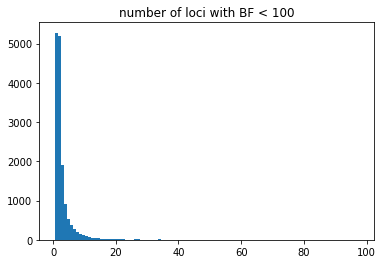



Eref 19470
	number of loci with meanBF >= 0 :  19470 (True)
	number of loci with meanBF >= 10 :  19412
	number of loci with meanBF >= 15 :  16491
	number of loci with meanBF >= 20 :  12981
	fraction of BF >= 15 :  0.85
	fraction of BF >= 10 :  1.0
	not all SNPs with BF >= 15 are consistently in top 1% : full (16972) vs 1% (16491) (diff = 481)
	not all SNPs with BF >= 20 are consistently in top 1% : full (13085) vs 1% (12981) (diff = 104)


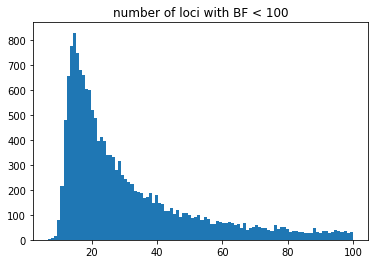



SHM 16867
	number of loci with meanBF >= 0 :  16867 (True)
	number of loci with meanBF >= 10 :  6444
	number of loci with meanBF >= 15 :  4454
	number of loci with meanBF >= 20 :  3446
	fraction of BF >= 15 :  0.26
	fraction of BF >= 10 :  0.38


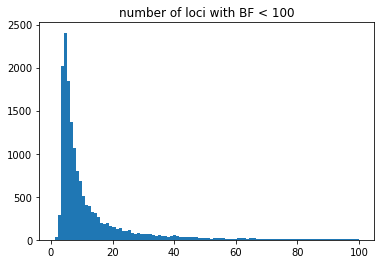



PAS 16254
	number of loci with meanBF >= 0 :  16254 (True)
	number of loci with meanBF >= 10 :  1460
	number of loci with meanBF >= 15 :  876
	number of loci with meanBF >= 20 :  622
	fraction of BF >= 15 :  0.05
	fraction of BF >= 10 :  0.09


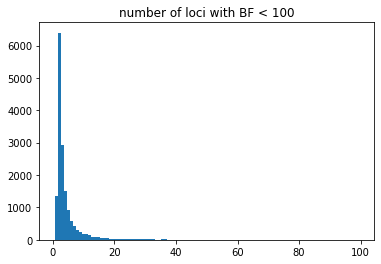



MAT 16982
	number of loci with meanBF >= 0 :  16982 (True)
	number of loci with meanBF >= 10 :  2112
	number of loci with meanBF >= 15 :  1273
	number of loci with meanBF >= 20 :  858
	fraction of BF >= 15 :  0.07
	fraction of BF >= 10 :  0.12


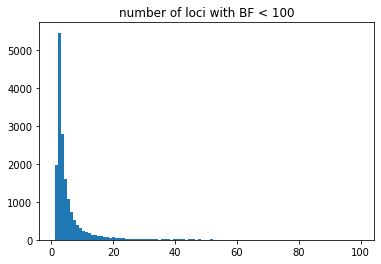



EMT 17379
	number of loci with meanBF >= 0 :  17379 (True)
	number of loci with meanBF >= 10 :  1978
	number of loci with meanBF >= 15 :  1234
	number of loci with meanBF >= 20 :  888
	fraction of BF >= 15 :  0.07
	fraction of BF >= 10 :  0.11


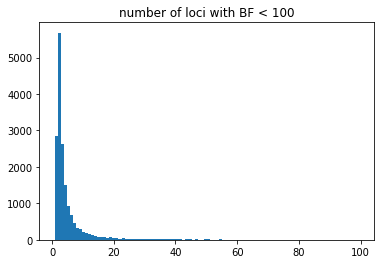



bFFP 15667
	number of loci with meanBF >= 0 :  15667 (True)
	number of loci with meanBF >= 10 :  762
	number of loci with meanBF >= 15 :  445
	number of loci with meanBF >= 20 :  308
	fraction of BF >= 15 :  0.03
	fraction of BF >= 10 :  0.05


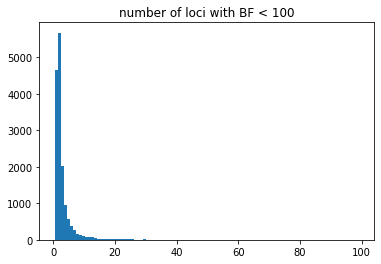



DD5 17069
	number of loci with meanBF >= 0 :  17069 (True)
	number of loci with meanBF >= 10 :  2418
	number of loci with meanBF >= 15 :  1485
	number of loci with meanBF >= 20 :  1040
	fraction of BF >= 15 :  0.09
	fraction of BF >= 10 :  0.14


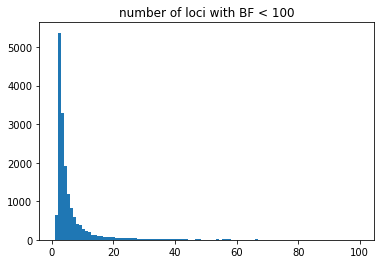



NFFD 16247
	number of loci with meanBF >= 0 :  16247 (True)
	number of loci with meanBF >= 10 :  1109
	number of loci with meanBF >= 15 :  686
	number of loci with meanBF >= 20 :  469
	fraction of BF >= 15 :  0.04
	fraction of BF >= 10 :  0.07


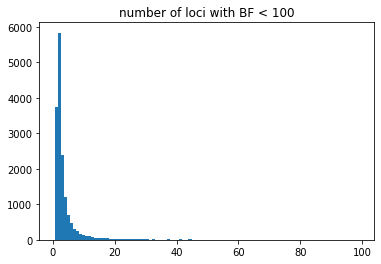



MCMT 17907
	number of loci with meanBF >= 0 :  17907 (True)
	number of loci with meanBF >= 10 :  2889
	number of loci with meanBF >= 15 :  1777
	number of loci with meanBF >= 20 :  1273
	fraction of BF >= 15 :  0.1
	fraction of BF >= 10 :  0.16


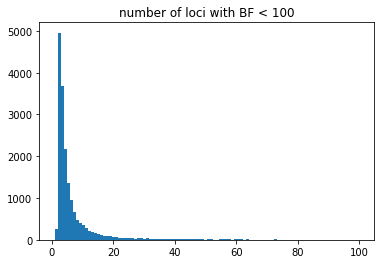



MWMT 17952
	number of loci with meanBF >= 0 :  17952 (True)
	number of loci with meanBF >= 10 :  4590
	number of loci with meanBF >= 15 :  2922
	number of loci with meanBF >= 20 :  2198
	fraction of BF >= 15 :  0.16
	fraction of BF >= 10 :  0.26


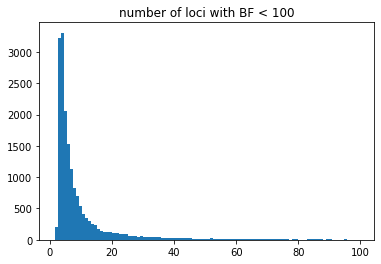



DD_0 17833
	number of loci with meanBF >= 0 :  17833 (True)
	number of loci with meanBF >= 10 :  2980
	number of loci with meanBF >= 15 :  1876
	number of loci with meanBF >= 20 :  1332
	fraction of BF >= 15 :  0.11
	fraction of BF >= 10 :  0.17


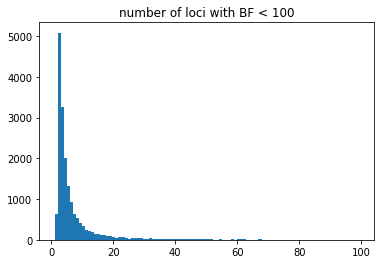



EXT 17805
	number of loci with meanBF >= 0 :  17805 (True)
	number of loci with meanBF >= 10 :  4812
	number of loci with meanBF >= 15 :  2964
	number of loci with meanBF >= 20 :  2075
	fraction of BF >= 15 :  0.17
	fraction of BF >= 10 :  0.27


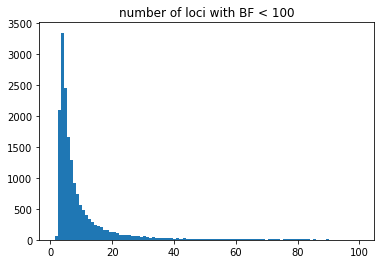



eFFP 16177
	number of loci with meanBF >= 0 :  16177 (True)
	number of loci with meanBF >= 10 :  1111
	number of loci with meanBF >= 15 :  637
	number of loci with meanBF >= 20 :  435
	fraction of BF >= 15 :  0.04
	fraction of BF >= 10 :  0.07


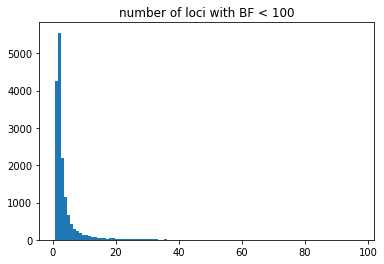



MSP 17995
	number of loci with meanBF >= 0 :  17995 (True)
	number of loci with meanBF >= 10 :  5088
	number of loci with meanBF >= 15 :  3230
	number of loci with meanBF >= 20 :  2365
	fraction of BF >= 15 :  0.18
	fraction of BF >= 10 :  0.28
	not all SNPs with BF >= 15 are consistently in top 1% : full (3231) vs 1% (3230) (diff = 1)


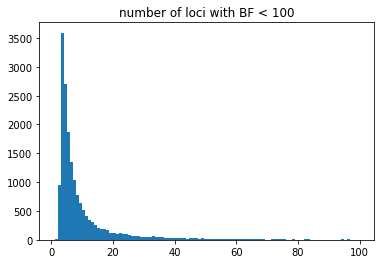



AHM 16695
	number of loci with meanBF >= 0 :  16695 (True)
	number of loci with meanBF >= 10 :  2028
	number of loci with meanBF >= 15 :  1287
	number of loci with meanBF >= 20 :  955
	fraction of BF >= 15 :  0.08
	fraction of BF >= 10 :  0.12


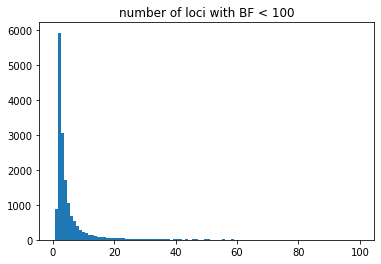



CMD 19192
	number of loci with meanBF >= 0 :  19192 (True)
	number of loci with meanBF >= 10 :  14526
	number of loci with meanBF >= 15 :  10155
	number of loci with meanBF >= 20 :  7703
	fraction of BF >= 15 :  0.53
	fraction of BF >= 10 :  0.76
	not all SNPs with BF >= 15 are consistently in top 1% : full (10179) vs 1% (10155) (diff = 24)
	not all SNPs with BF >= 20 are consistently in top 1% : full (7711) vs 1% (7703) (diff = 8)


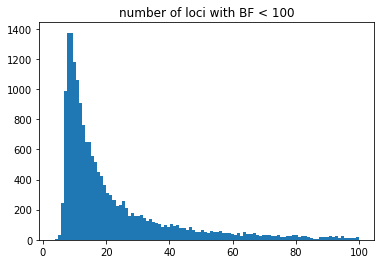



MAP 17581
	number of loci with meanBF >= 0 :  17581 (True)
	number of loci with meanBF >= 10 :  2292
	number of loci with meanBF >= 15 :  1368
	number of loci with meanBF >= 20 :  948
	fraction of BF >= 15 :  0.08
	fraction of BF >= 10 :  0.13


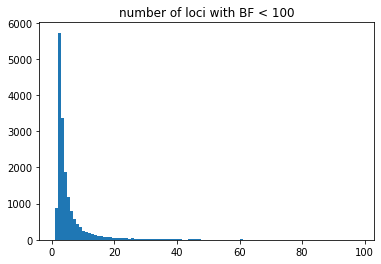



TD 18239
	number of loci with meanBF >= 0 :  18239 (True)
	number of loci with meanBF >= 10 :  3419
	number of loci with meanBF >= 15 :  2284
	number of loci with meanBF >= 20 :  1742
	fraction of BF >= 15 :  0.13
	fraction of BF >= 10 :  0.19


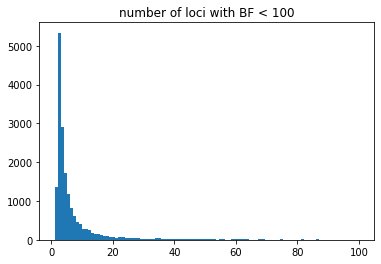




Fraction of meanBF >=15 across envs


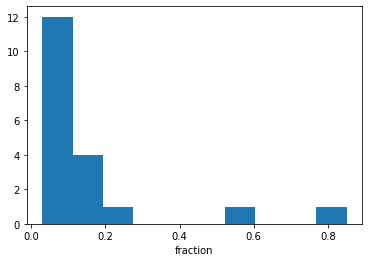

,FFP,Eref,SHM,PAS,MAT,EMT,bFFP,DD5,NFFD,MCMT,MWMT,DD_0,EXT,eFFP,MSP,AHM,CMD,MAP,TD
0,0.03,0.85,0.26,0.05,0.07,0.07,0.03,0.09,0.04,0.1,0.16,0.11,0.17,0.04,0.18,0.08,0.53,0.08,0.13


In [6]:
# for **ONLY** those loci that are consistently ranked in top 1%
# print histograms of bayes factor for each environment
# print fraction of top 1%BFs that have BF ≥ 15 or BF ≥ 20
# also look at histogram for BFs < 100

# also count number of loci across all SNPs that have BF ≥ 15 or BF ≥ 20, print if count doesn't match top 1%
fracs = defaultdict(dict)
for env,df in envdfs.items():
    df = df[df['rank_consistency_top1perc_for-gte3chains'] == True]
    BFs = df['mean_BF']
    small15 = sum(BFs >= 15)
    small20 = sum(BFs >= 20)
    print(ColorText(env).bold(), nrow(df))
    print('\tnumber of loci with meanBF >= 0 : ', sum(BFs >= 0), "(%s)" % str(sum(BFs >= 0) == nrow(df)))
    print('\tnumber of loci with meanBF >= 10 : ', sum(BFs >= 10))
    print('\tnumber of loci with meanBF >= 15 : ', small15)
    print('\tnumber of loci with meanBF >= 20 : ', small20)
    frac = round(sum(BFs >= 15)/nrow(df), 2)
    frac2 = round(sum(BFs >= 10)/nrow(df), 2)
    fracs[env][0] = frac
    print('\tfraction of BF >= 15 : ', frac)
    print('\tfraction of BF >= 10 : ', frac2)
    sum15 = sum(envdfs[env]['mean_BF'] >= 15)
    sum20 = sum(envdfs[env]['mean_BF'] >= 20)
    if small15 != sum15:
        text = '\tnot all SNPs with BF >= 15 are consistently in top 1%'
        print(ColorText(f"{text} : full ({sum15}) vs 1% ({small15}) (diff = {sum15 - small15})").warn().bold())
    if small20 != sum20:
        text = '\tnot all SNPs with BF >= 20 are consistently in top 1%'
        print(ColorText(f"{text} : full ({sum20}) vs 1% ({small20}) (diff = {sum20 - small20})").warn().bold())
    plt.hist(BFs[BFs<100], bins=100)
    plt.title('number of loci with BF < 100')
    plt.show()
    print('\n')

# create histogram for fraction of SNPs in consistent top 1% across environments
print(ColorText('\nFraction of meanBF >=15 across envs').bold())
fracdf = pd.DataFrame(fracs)
plt.hist(fracdf.loc[0,:])
plt.xlabel('fraction')
plt.show()
fracdf

In [7]:
df[df['rank_mean_BF']==1]

,chain_1-COVARIABLE,chain_1-MRK,chain_1-M_Pearson,chain_1-SD_Pearson,chain_1-BF(dB),chain_1-Beta_is,chain_1-SD_Beta_is,chain_1-eBPis,chain_1-env,chain_2-COVARIABLE,chain_2-MRK,chain_2-M_Pearson,chain_2-SD_Pearson,chain_2-BF(dB),chain_2-Beta_is,chain_2-SD_Beta_is,chain_2-eBPis,chain_2-env,chain_3-COVARIABLE,chain_3-MRK,chain_3-M_Pearson,chain_3-SD_Pearson,chain_3-BF(dB),chain_3-Beta_is,chain_3-SD_Beta_is,chain_3-eBPis,chain_3-env,chain_4-COVARIABLE,chain_4-MRK,chain_4-M_Pearson,chain_4-SD_Pearson,chain_4-BF(dB),chain_4-Beta_is,chain_4-SD_Beta_is,chain_4-eBPis,chain_4-env,chain_5-COVARIABLE,chain_5-MRK,chain_5-M_Pearson,chain_5-SD_Pearson,chain_5-BF(dB),chain_5-Beta_is,chain_5-SD_Beta_is,chain_5-eBPis,chain_5-env,rank_chain_1-BF,rank_chain_2-BF,rank_chain_3-BF,rank_chain_4-BF,rank_chain_5-BF,mean_BF,rank_mean_BF,BF_gte20_for-gte3chains,BF_gte15_for-gte3chains,rank_consistency_top1perc_for-gte3chains
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
jcf7190000135168-4611,4,841,0.67904,0.033341,96.40002,0.16222,0.010318,15.35253,TD,4,841,0.674374,0.035989,96.446112,0.162025,0.010255,15.35253,TD,4,841,0.677824,0.033547,97.845801,0.161898,0.0101,15.35253,TD,4,841,0.679366,0.032356,97.038152,0.162914,0.009683,15.35253,TD,4,841,0.676919,0.036138,100.633408,0.162797,0.010502,15.35253,TD,1,1,1,1,1,5.851536e+09,1,True,True,True
